# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, hidden4_size, hidden5_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.Tanh(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.Tanh(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.Tanh(),
            nn.Linear(hidden3_size, hidden4_size),
            nn.Tanh(),
            nn.Linear(hidden4_size, hidden5_size),
            nn.Tanh(),
            nn.Linear(hidden5_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): Tanh()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): Tanh()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): Tanh()
    (6): Linear(in_features=200, out_features=200, bias=True)
    (7): Tanh()
    (8): Linear(in_features=200, out_features=200, bias=True)
    (9): Tanh()
    (10): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.7996
Epoch 1/200, Iteration 2/12, Loss: 0.6541
Epoch 1/200, Iteration 3/12, Loss: 1.3973
Epoch 1/200, Iteration 4/12, Loss: 1.5899
Epoch 1/200, Iteration 5/12, Loss: 0.7788
Epoch 1/200, Iteration 6/12, Loss: 1.2374
Epoch 1/200, Iteration 7/12, Loss: 0.8679
Epoch 1/200, Iteration 8/12, Loss: 0.5441
Epoch 1/200, Iteration 9/12, Loss: 0.5159
Epoch 1/200, Iteration 10/12, Loss: 0.5713
Epoch 1/200, Iteration 11/12, Loss: 0.4738
Epoch 1/200, Iteration 12/12, Loss: 0.5547
Epoch 1/200, Iteration 13/12, Loss: 0.3818
Train Error: 
 Accuracy: 61.38%, Avg loss: 0.526435, MRE: 0.437452, MAE: 0.073949 

Test Error: 
 Accuracy: 61.5%, Avg loss: 0.495604, MRE: 0.360766, MAE: 0.066402 

Epoch 2/200, Iteration 1/12, Loss: 0.5153
Epoch 2/200, Iteration 2/12, Loss: 0.4678
Epoch 2/200, Iteration 3/12, Loss: 0.4420
Epoch 2/200, Iteration 4/12, Loss: 0.4036
Epoch 2/200, Iteration 5/12, Loss: 0.4442
Epoch 2/200, Iteration 6/12, Loss: 0.3982
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 85.25%, Avg loss: 0.188472, MRE: 0.131711, MAE: 0.026452 

Test Error: 
 Accuracy: 81.5%, Avg loss: 0.195880, MRE: 0.115511, MAE: 0.026828 

Epoch 13/200, Iteration 1/12, Loss: 0.1713
Epoch 13/200, Iteration 2/12, Loss: 0.1886
Epoch 13/200, Iteration 3/12, Loss: 0.2303
Epoch 13/200, Iteration 4/12, Loss: 0.2044
Epoch 13/200, Iteration 5/12, Loss: 0.2671
Epoch 13/200, Iteration 6/12, Loss: 0.2263
Epoch 13/200, Iteration 7/12, Loss: 0.2048
Epoch 13/200, Iteration 8/12, Loss: 0.1962
Epoch 13/200, Iteration 9/12, Loss: 0.1944
Epoch 13/200, Iteration 10/12, Loss: 0.2198
Epoch 13/200, Iteration 11/12, Loss: 0.2148
Epoch 13/200, Iteration 12/12, Loss: 0.2339
Epoch 13/200, Iteration 13/12, Loss: 0.2189
Train Error: 
 Accuracy: 79.88%, Avg loss: 0.166106, MRE: 0.124311, MAE: 0.023988 

Test Error: 
 Accuracy: 82.5%, Avg loss: 0.164337, MRE: 0.109127, MAE: 0.023429 

Epoch 14/200, Iteration 1/12, Loss: 0.1726
Epoch 14/200, Iteration 2/12, Loss: 0.1729
Epoch 14/200, Itera

Train Error: 
 Accuracy: 59.13%, Avg loss: 0.137264, MRE: 0.106356, MAE: 0.018521 

Test Error: 
 Accuracy: 56.0%, Avg loss: 0.137144, MRE: 0.090667, MAE: 0.018450 

Epoch 25/200, Iteration 1/12, Loss: 0.1281
Epoch 25/200, Iteration 2/12, Loss: 0.1779
Epoch 25/200, Iteration 3/12, Loss: 0.1570
Epoch 25/200, Iteration 4/12, Loss: 0.1909
Epoch 25/200, Iteration 5/12, Loss: 0.1161
Epoch 25/200, Iteration 6/12, Loss: 0.1422
Epoch 25/200, Iteration 7/12, Loss: 0.1145
Epoch 25/200, Iteration 8/12, Loss: 0.1632
Epoch 25/200, Iteration 9/12, Loss: 0.1241
Epoch 25/200, Iteration 10/12, Loss: 0.1561
Epoch 25/200, Iteration 11/12, Loss: 0.1601
Epoch 25/200, Iteration 12/12, Loss: 0.1200
Epoch 25/200, Iteration 13/12, Loss: 0.1539
Train Error: 
 Accuracy: 73.75%, Avg loss: 0.130017, MRE: 0.090839, MAE: 0.017599 

Test Error: 
 Accuracy: 73.5%, Avg loss: 0.122458, MRE: 0.071997, MAE: 0.016973 

Epoch 26/200, Iteration 1/12, Loss: 0.1458
Epoch 26/200, Iteration 2/12, Loss: 0.1418
Epoch 26/200, Itera

Train Error: 
 Accuracy: 81.38%, Avg loss: 0.065878, MRE: 0.060499, MAE: 0.008385 

Test Error: 
 Accuracy: 79.5%, Avg loss: 0.064865, MRE: 0.045458, MAE: 0.008359 

Epoch 37/200, Iteration 1/12, Loss: 0.0646
Epoch 37/200, Iteration 2/12, Loss: 0.0634
Epoch 37/200, Iteration 3/12, Loss: 0.0583
Epoch 37/200, Iteration 4/12, Loss: 0.0606
Epoch 37/200, Iteration 5/12, Loss: 0.0544
Epoch 37/200, Iteration 6/12, Loss: 0.0622
Epoch 37/200, Iteration 7/12, Loss: 0.0449
Epoch 37/200, Iteration 8/12, Loss: 0.0530
Epoch 37/200, Iteration 9/12, Loss: 0.0623
Epoch 37/200, Iteration 10/12, Loss: 0.0497
Epoch 37/200, Iteration 11/12, Loss: 0.0574
Epoch 37/200, Iteration 12/12, Loss: 0.0569
Epoch 37/200, Iteration 13/12, Loss: 0.0529
Train Error: 
 Accuracy: 94.12%, Avg loss: 0.046525, MRE: 0.043789, MAE: 0.006021 

Test Error: 
 Accuracy: 93.5%, Avg loss: 0.052388, MRE: 0.035119, MAE: 0.006890 

Epoch 38/200, Iteration 1/12, Loss: 0.0482
Epoch 38/200, Iteration 2/12, Loss: 0.0451
Epoch 38/200, Itera

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.026995, MRE: 0.025258, MAE: 0.003430 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.031143, MRE: 0.020251, MAE: 0.003937 

Epoch 49/200, Iteration 1/12, Loss: 0.0284
Epoch 49/200, Iteration 2/12, Loss: 0.0297
Epoch 49/200, Iteration 3/12, Loss: 0.0243
Epoch 49/200, Iteration 4/12, Loss: 0.0205
Epoch 49/200, Iteration 5/12, Loss: 0.0291
Epoch 49/200, Iteration 6/12, Loss: 0.0310
Epoch 49/200, Iteration 7/12, Loss: 0.0306
Epoch 49/200, Iteration 8/12, Loss: 0.0274
Epoch 49/200, Iteration 9/12, Loss: 0.0271
Epoch 49/200, Iteration 10/12, Loss: 0.0253
Epoch 49/200, Iteration 11/12, Loss: 0.0250
Epoch 49/200, Iteration 12/12, Loss: 0.0198
Epoch 49/200, Iteration 13/12, Loss: 0.0259
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.027463, MRE: 0.024171, MAE: 0.003483 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.030776, MRE: 0.020442, MAE: 0.003851 

Epoch 50/200, Iteration 1/12, Loss: 0.0296
Epoch 50/200, Iteration 2/12, Loss: 0.0315
Epoch 50/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.024756, MRE: 0.017749, MAE: 0.003220 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.029349, MRE: 0.017870, MAE: 0.003794 

Epoch 61/200, Iteration 1/12, Loss: 0.0257
Epoch 61/200, Iteration 2/12, Loss: 0.0268
Epoch 61/200, Iteration 3/12, Loss: 0.0264
Epoch 61/200, Iteration 4/12, Loss: 0.0222
Epoch 61/200, Iteration 5/12, Loss: 0.0268
Epoch 61/200, Iteration 6/12, Loss: 0.0253
Epoch 61/200, Iteration 7/12, Loss: 0.0314
Epoch 61/200, Iteration 8/12, Loss: 0.0304
Epoch 61/200, Iteration 9/12, Loss: 0.0231
Epoch 61/200, Iteration 10/12, Loss: 0.0268
Epoch 61/200, Iteration 11/12, Loss: 0.0198
Epoch 61/200, Iteration 12/12, Loss: 0.0200
Epoch 61/200, Iteration 13/12, Loss: 0.0171
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.021927, MRE: 0.016771, MAE: 0.002842 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.027345, MRE: 0.018065, MAE: 0.003407 

Epoch 62/200, Iteration 1/12, Loss: 0.0227
Epoch 62/200, Iteration 2/12, Loss: 0.0220
Epoch 62/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.020257, MRE: 0.016389, MAE: 0.002647 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.025735, MRE: 0.016774, MAE: 0.003284 

Epoch 73/200, Iteration 1/12, Loss: 0.0218
Epoch 73/200, Iteration 2/12, Loss: 0.0166
Epoch 73/200, Iteration 3/12, Loss: 0.0150
Epoch 73/200, Iteration 4/12, Loss: 0.0194
Epoch 73/200, Iteration 5/12, Loss: 0.0189
Epoch 73/200, Iteration 6/12, Loss: 0.0191
Epoch 73/200, Iteration 7/12, Loss: 0.0205
Epoch 73/200, Iteration 8/12, Loss: 0.0224
Epoch 73/200, Iteration 9/12, Loss: 0.0200
Epoch 73/200, Iteration 10/12, Loss: 0.0200
Epoch 73/200, Iteration 11/12, Loss: 0.0245
Epoch 73/200, Iteration 12/12, Loss: 0.0201
Epoch 73/200, Iteration 13/12, Loss: 0.0169
Train Error: 
 Accuracy: 99.5%, Avg loss: 0.018778, MRE: 0.015011, MAE: 0.002557 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.025724, MRE: 0.016846, MAE: 0.003380 

Epoch 74/200, Iteration 1/12, Loss: 0.0162
Epoch 74/200, Iteration 2/12, Loss: 0.0192
Epoch 74/200, Iterat

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006682, MRE: 0.006497, MAE: 0.000871 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.019692, MRE: 0.012851, MAE: 0.002509 

Epoch 85/200, Iteration 1/12, Loss: 0.0069
Epoch 85/200, Iteration 2/12, Loss: 0.0067
Epoch 85/200, Iteration 3/12, Loss: 0.0064
Epoch 85/200, Iteration 4/12, Loss: 0.0062
Epoch 85/200, Iteration 5/12, Loss: 0.0063
Epoch 85/200, Iteration 6/12, Loss: 0.0090
Epoch 85/200, Iteration 7/12, Loss: 0.0069
Epoch 85/200, Iteration 8/12, Loss: 0.0070
Epoch 85/200, Iteration 9/12, Loss: 0.0071
Epoch 85/200, Iteration 10/12, Loss: 0.0059
Epoch 85/200, Iteration 11/12, Loss: 0.0064
Epoch 85/200, Iteration 12/12, Loss: 0.0080
Epoch 85/200, Iteration 13/12, Loss: 0.0060
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006630, MRE: 0.006305, MAE: 0.000896 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.019553, MRE: 0.012836, MAE: 0.002512 

Epoch 86/200, Iteration 1/12, Loss: 0.0063
Epoch 86/200, Iteration 2/12, Loss: 0.0064
Epoch 86/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006317, MRE: 0.005844, MAE: 0.000829 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.019322, MRE: 0.012658, MAE: 0.002465 

Epoch 97/200, Iteration 1/12, Loss: 0.0064
Epoch 97/200, Iteration 2/12, Loss: 0.0060
Epoch 97/200, Iteration 3/12, Loss: 0.0080
Epoch 97/200, Iteration 4/12, Loss: 0.0059
Epoch 97/200, Iteration 5/12, Loss: 0.0056
Epoch 97/200, Iteration 6/12, Loss: 0.0059
Epoch 97/200, Iteration 7/12, Loss: 0.0055
Epoch 97/200, Iteration 8/12, Loss: 0.0065
Epoch 97/200, Iteration 9/12, Loss: 0.0063
Epoch 97/200, Iteration 10/12, Loss: 0.0064
Epoch 97/200, Iteration 11/12, Loss: 0.0072
Epoch 97/200, Iteration 12/12, Loss: 0.0073
Epoch 97/200, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.006341, MRE: 0.007372, MAE: 0.000837 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.019034, MRE: 0.012467, MAE: 0.002437 

Epoch 98/200, Iteration 1/12, Loss: 0.0054
Epoch 98/200, Iteration 2/12, Loss: 0.0050
Epoch 98/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005987, MRE: 0.005587, MAE: 0.000780 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.019467, MRE: 0.012703, MAE: 0.002477 

Epoch 109/200, Iteration 1/12, Loss: 0.0071
Epoch 109/200, Iteration 2/12, Loss: 0.0073
Epoch 109/200, Iteration 3/12, Loss: 0.0052
Epoch 109/200, Iteration 4/12, Loss: 0.0053
Epoch 109/200, Iteration 5/12, Loss: 0.0068
Epoch 109/200, Iteration 6/12, Loss: 0.0050
Epoch 109/200, Iteration 7/12, Loss: 0.0053
Epoch 109/200, Iteration 8/12, Loss: 0.0048
Epoch 109/200, Iteration 9/12, Loss: 0.0061
Epoch 109/200, Iteration 10/12, Loss: 0.0055
Epoch 109/200, Iteration 11/12, Loss: 0.0059
Epoch 109/200, Iteration 12/12, Loss: 0.0059
Epoch 109/200, Iteration 13/12, Loss: 0.0090
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005485, MRE: 0.005172, MAE: 0.000725 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018787, MRE: 0.012191, MAE: 0.002386 

Epoch 110/200, Iteration 1/12, Loss: 0.0043
Epoch 110/200, Iteration 2/12, Loss: 0.0058
Epoc

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005176, MRE: 0.004759, MAE: 0.000709 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018754, MRE: 0.012127, MAE: 0.002389 

Epoch 121/200, Iteration 1/12, Loss: 0.0062
Epoch 121/200, Iteration 2/12, Loss: 0.0066
Epoch 121/200, Iteration 3/12, Loss: 0.0044
Epoch 121/200, Iteration 4/12, Loss: 0.0050
Epoch 121/200, Iteration 5/12, Loss: 0.0051
Epoch 121/200, Iteration 6/12, Loss: 0.0047
Epoch 121/200, Iteration 7/12, Loss: 0.0067
Epoch 121/200, Iteration 8/12, Loss: 0.0068
Epoch 121/200, Iteration 9/12, Loss: 0.0054
Epoch 121/200, Iteration 10/12, Loss: 0.0067
Epoch 121/200, Iteration 11/12, Loss: 0.0042
Epoch 121/200, Iteration 12/12, Loss: 0.0045
Epoch 121/200, Iteration 13/12, Loss: 0.0055
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005487, MRE: 0.005066, MAE: 0.000711 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018532, MRE: 0.012101, MAE: 0.002365 

Epoch 122/200, Iteration 1/12, Loss: 0.0054
Epoch 122/200, Iteration 2/12, Loss: 0.0046
Epoc

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004661, MRE: 0.004663, MAE: 0.000614 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018629, MRE: 0.012077, MAE: 0.002379 

Epoch 133/200, Iteration 1/12, Loss: 0.0050
Epoch 133/200, Iteration 2/12, Loss: 0.0041
Epoch 133/200, Iteration 3/12, Loss: 0.0040
Epoch 133/200, Iteration 4/12, Loss: 0.0042
Epoch 133/200, Iteration 5/12, Loss: 0.0040
Epoch 133/200, Iteration 6/12, Loss: 0.0053
Epoch 133/200, Iteration 7/12, Loss: 0.0074
Epoch 133/200, Iteration 8/12, Loss: 0.0046
Epoch 133/200, Iteration 9/12, Loss: 0.0046
Epoch 133/200, Iteration 10/12, Loss: 0.0064
Epoch 133/200, Iteration 11/12, Loss: 0.0057
Epoch 133/200, Iteration 12/12, Loss: 0.0047
Epoch 133/200, Iteration 13/12, Loss: 0.0038
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004714, MRE: 0.004393, MAE: 0.000633 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018761, MRE: 0.012022, MAE: 0.002401 

Epoch 134/200, Iteration 1/12, Loss: 0.0036
Epoch 134/200, Iteration 2/12, Loss: 0.0039
Epoc

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005552, MRE: 0.004769, MAE: 0.000717 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018478, MRE: 0.011981, MAE: 0.002372 

Epoch 145/200, Iteration 1/12, Loss: 0.0053
Epoch 145/200, Iteration 2/12, Loss: 0.0060
Epoch 145/200, Iteration 3/12, Loss: 0.0073
Epoch 145/200, Iteration 4/12, Loss: 0.0055
Epoch 145/200, Iteration 5/12, Loss: 0.0054
Epoch 145/200, Iteration 6/12, Loss: 0.0042
Epoch 145/200, Iteration 7/12, Loss: 0.0045
Epoch 145/200, Iteration 8/12, Loss: 0.0058
Epoch 145/200, Iteration 9/12, Loss: 0.0041
Epoch 145/200, Iteration 10/12, Loss: 0.0047
Epoch 145/200, Iteration 11/12, Loss: 0.0056
Epoch 145/200, Iteration 12/12, Loss: 0.0050
Epoch 145/200, Iteration 13/12, Loss: 0.0060
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.005022, MRE: 0.004476, MAE: 0.000648 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018586, MRE: 0.011941, MAE: 0.002379 

Epoch 146/200, Iteration 1/12, Loss: 0.0054
Epoch 146/200, Iteration 2/12, Loss: 0.0043
Epoc

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.005102, MRE: 0.004512, MAE: 0.000670 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018945, MRE: 0.012158, MAE: 0.002406 

Epoch 157/200, Iteration 1/12, Loss: 0.0055
Epoch 157/200, Iteration 2/12, Loss: 0.0048
Epoch 157/200, Iteration 3/12, Loss: 0.0047
Epoch 157/200, Iteration 4/12, Loss: 0.0064
Epoch 157/200, Iteration 5/12, Loss: 0.0046
Epoch 157/200, Iteration 6/12, Loss: 0.0042
Epoch 157/200, Iteration 7/12, Loss: 0.0047
Epoch 157/200, Iteration 8/12, Loss: 0.0060
Epoch 157/200, Iteration 9/12, Loss: 0.0047
Epoch 157/200, Iteration 10/12, Loss: 0.0063
Epoch 157/200, Iteration 11/12, Loss: 0.0050
Epoch 157/200, Iteration 12/12, Loss: 0.0042
Epoch 157/200, Iteration 13/12, Loss: 0.0049
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.004948, MRE: 0.004936, MAE: 0.000681 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018980, MRE: 0.012125, MAE: 0.002408 

Epoch 158/200, Iteration 1/12, Loss: 0.0047
Epoch 158/200, Iteration 2/12, Loss: 0.0062
Epoc

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003278, MRE: 0.003397, MAE: 0.000451 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018396, MRE: 0.011797, MAE: 0.002348 

Epoch 169/200, Iteration 1/12, Loss: 0.0033
Epoch 169/200, Iteration 2/12, Loss: 0.0023
Epoch 169/200, Iteration 3/12, Loss: 0.0034
Epoch 169/200, Iteration 4/12, Loss: 0.0037
Epoch 169/200, Iteration 5/12, Loss: 0.0039
Epoch 169/200, Iteration 6/12, Loss: 0.0024
Epoch 169/200, Iteration 7/12, Loss: 0.0035
Epoch 169/200, Iteration 8/12, Loss: 0.0035
Epoch 169/200, Iteration 9/12, Loss: 0.0025
Epoch 169/200, Iteration 10/12, Loss: 0.0040
Epoch 169/200, Iteration 11/12, Loss: 0.0038
Epoch 169/200, Iteration 12/12, Loss: 0.0029
Epoch 169/200, Iteration 13/12, Loss: 0.0032
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003201, MRE: 0.003322, MAE: 0.000438 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018424, MRE: 0.011859, MAE: 0.002347 

Epoch 170/200, Iteration 1/12, Loss: 0.0023
Epoch 170/200, Iteration 2/12, Loss: 0.0025
Epoc

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003183, MRE: 0.003276, MAE: 0.000429 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018400, MRE: 0.011817, MAE: 0.002347 

Epoch 181/200, Iteration 1/12, Loss: 0.0047
Epoch 181/200, Iteration 2/12, Loss: 0.0041
Epoch 181/200, Iteration 3/12, Loss: 0.0030
Epoch 181/200, Iteration 4/12, Loss: 0.0023
Epoch 181/200, Iteration 5/12, Loss: 0.0031
Epoch 181/200, Iteration 6/12, Loss: 0.0031
Epoch 181/200, Iteration 7/12, Loss: 0.0026
Epoch 181/200, Iteration 8/12, Loss: 0.0033
Epoch 181/200, Iteration 9/12, Loss: 0.0026
Epoch 181/200, Iteration 10/12, Loss: 0.0030
Epoch 181/200, Iteration 11/12, Loss: 0.0033
Epoch 181/200, Iteration 12/12, Loss: 0.0025
Epoch 181/200, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003080, MRE: 0.003305, MAE: 0.000422 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018399, MRE: 0.011807, MAE: 0.002347 

Epoch 182/200, Iteration 1/12, Loss: 0.0035
Epoch 182/200, Iteration 2/12, Loss: 0.0036
Epoc

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003043, MRE: 0.003262, MAE: 0.000415 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018410, MRE: 0.011807, MAE: 0.002349 

Epoch 193/200, Iteration 1/12, Loss: 0.0025
Epoch 193/200, Iteration 2/12, Loss: 0.0026
Epoch 193/200, Iteration 3/12, Loss: 0.0023
Epoch 193/200, Iteration 4/12, Loss: 0.0024
Epoch 193/200, Iteration 5/12, Loss: 0.0027
Epoch 193/200, Iteration 6/12, Loss: 0.0028
Epoch 193/200, Iteration 7/12, Loss: 0.0021
Epoch 193/200, Iteration 8/12, Loss: 0.0042
Epoch 193/200, Iteration 9/12, Loss: 0.0034
Epoch 193/200, Iteration 10/12, Loss: 0.0037
Epoch 193/200, Iteration 11/12, Loss: 0.0049
Epoch 193/200, Iteration 12/12, Loss: 0.0031
Epoch 193/200, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.002983, MRE: 0.003167, MAE: 0.000408 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.018482, MRE: 0.011851, MAE: 0.002359 

Epoch 194/200, Iteration 1/12, Loss: 0.0028
Epoch 194/200, Iteration 2/12, Loss: 0.0027
Epoc

#### Plots loss vs Epoch

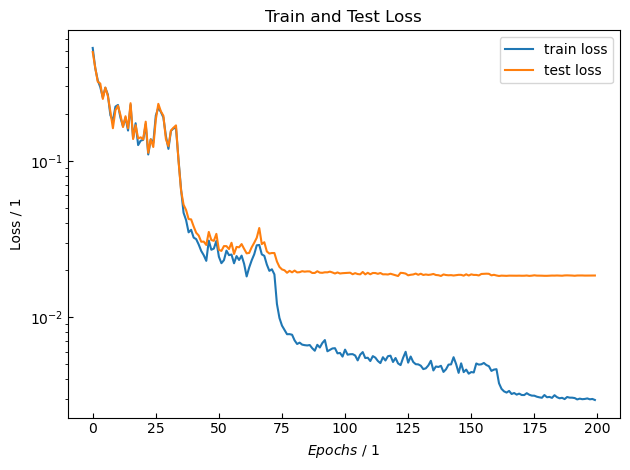

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999185237138989 , R^2(NH3) = 0.9999318504537229
Test Dataset: R^2(H2) = 0.9994389564075217 , R^2(NH3) = 0.9991982309113036
Max Error Training: |x_H2 - x_H2,pred| = 0.036493592542287234 , |x_NH3 - x_NH3,pred| = 0.011154039973425511
Max Error Test: |x_H2 - x_H2,pred| = 0.016715633667627794 , |x_NH3 - x_NH3,pred| = 0.01284110923707893


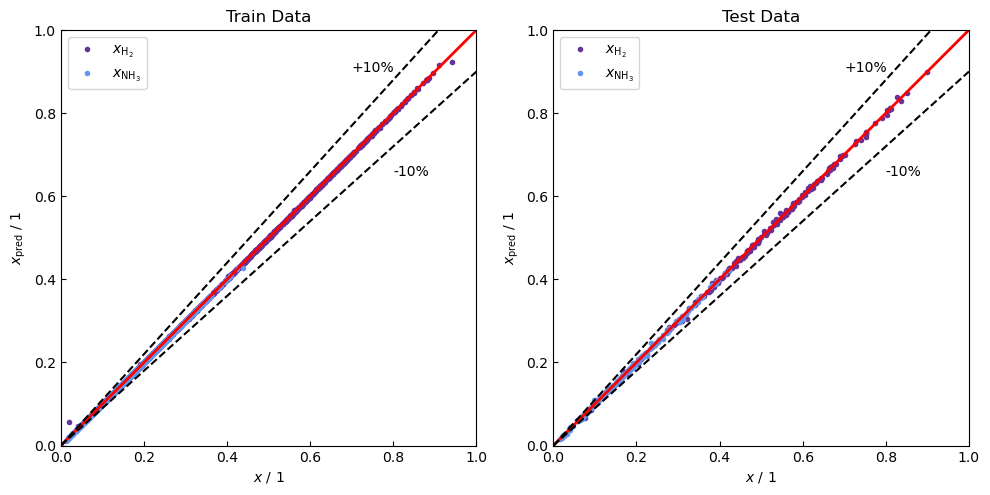

In [11]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

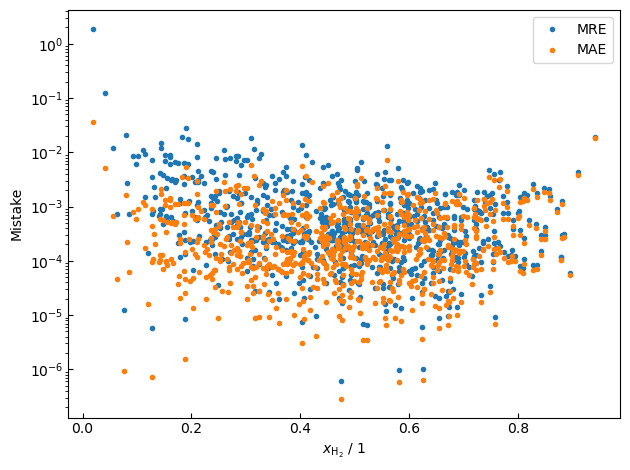

In [12]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

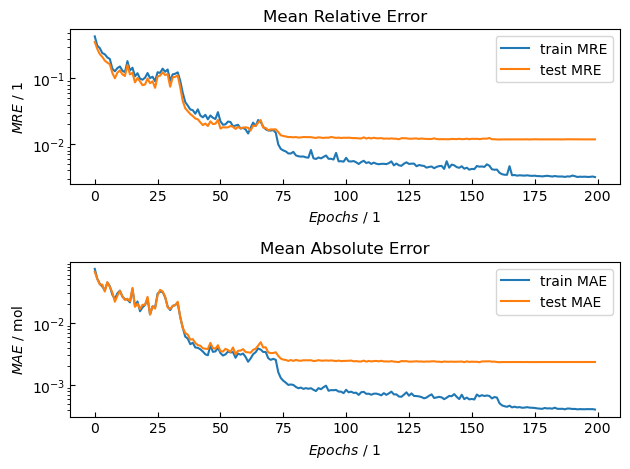

In [13]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

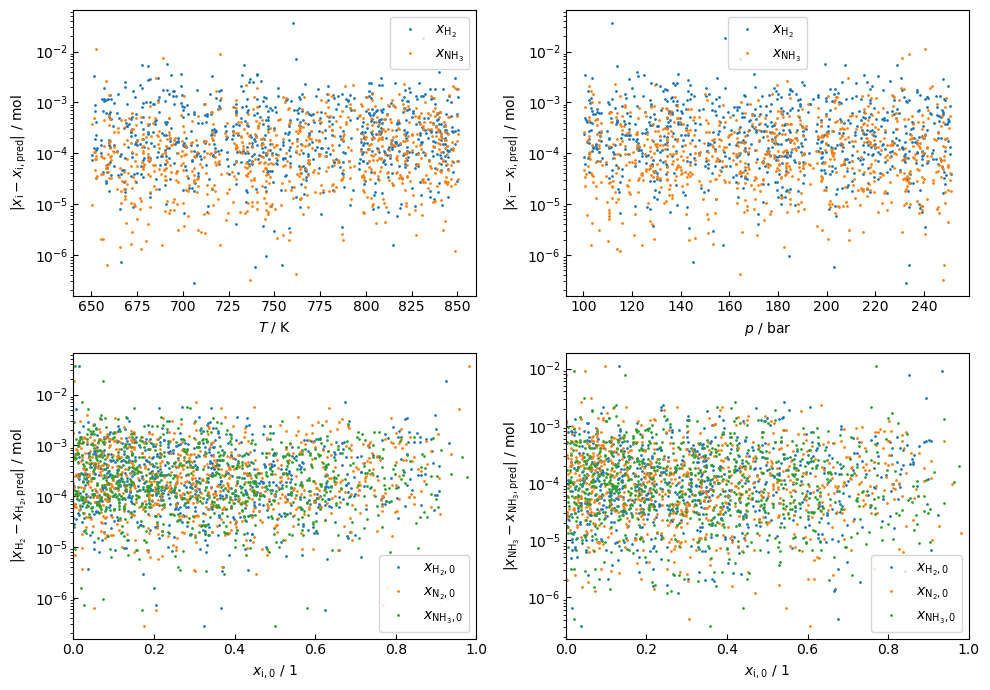

In [14]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

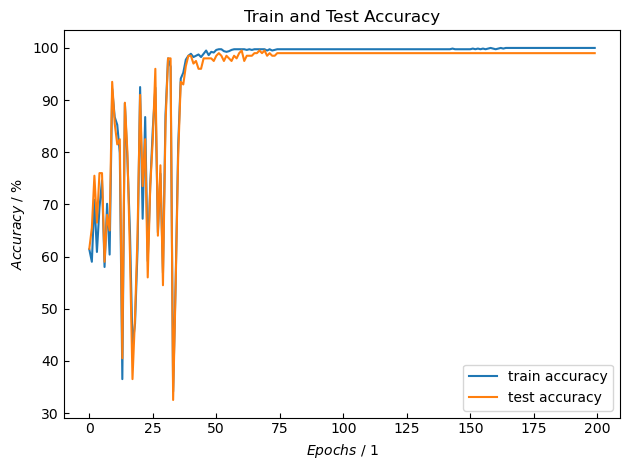

In [15]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [16]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 1.1448,  0.0237,  1.2820, -0.8460, -0.3934],
        [-0.9108,  1.2135, -0.1213,  0.7474, -0.6448],
        [ 0.4074, -1.6347, -0.1282,  0.4852, -0.3701],
        [-1.0963,  1.4259, -0.4281, -0.3278,  0.7552],
        [ 1.2370,  1.4823,  2.2752, -0.9064, -1.3064],
        [-0.1724,  0.2046, -1.4377,  2.4526, -1.0958],
        [-1.5506,  1.4542,  1.5789, -0.4811, -1.0578],
        [-0.2075, -1.6050, -1.4096,  2.1889, -0.8539],
        [ 0.1993, -0.4285,  0.7691, -0.3588, -0.3880],
        [ 1.1556, -0.8490, -0.2966,  0.8468, -0.5744],
        [ 1.6188,  0.9871,  0.0479,  0.5436, -0.6027],
        [-0.6508,  1.3536,  2.1032, -1.2638, -0.7723],
        [-0.1491,  0.1733, -0.6346,  0.9814, -0.3803],
        [-0.6428, -0.1032, -0.9699,  0.3975,  0.5456],
        [-1.1021, -0.9355, -1.3447, -1.0576,  2.4007],
        [-1.2624, -1.4083, -1.4108,  2.5834, -1.2559],
        [-0.2069, -1.6704, -0.7475, -0.9204,  1.6744],
        [-1.0013, -1.1647, -0.7896,  1.8161, -1.0813],
        [ 

#### Einblick in Netzwerk

In [17]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-0.2122, -0.2176,  0.0143,  0.4145, -0.1155],
         [ 0.2309, -0.2775,  0.0812, -0.1280,  0.2970],
         [-0.0254,  0.0735,  0.0985, -0.2100,  0.4865],
         [-0.2760,  0.2391, -0.1967,  0.2917,  0.2438],
         [-0.3088, -0.0444, -0.2296,  0.3963, -0.3078],
         [-0.0771,  0.1278, -0.0981,  0.4797,  0.0404],
         [-0.4126,  0.0156, -0.3508, -0.1732,  0.1122],
         [ 0.1374,  0.2852,  0.2365,  0.1386, -0.0534],
         [-0.0033,  0.1088, -0.2015,  0.1432, -0.0088],
         [ 0.3567,  0.1264,  0.2746, -0.1835, -0.0716],
         [ 0.5425, -0.3642,  0.2750, -0.0240,  0.2662],
         [ 0.0408,  0.2432, -0.2820, -0.2304,  0.4010],
         [ 0.2505, -0.2236,  0.2351, -0.1181,  0.3321],
         [-0.4943,  0.1292,  0.1744,  0.0262,  0.0030],
         [ 0.4356, -0.1302,  0.1456, -0.2711, -0.1729],
         [-0.1401, -0.3159, -0.1546,  0.4430, -0.1061],
         [ 0.2939,  0.1889,  0.1384,  0.3861, -0.0015],
         [-0.3171,  0.200

In [18]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.1083, 0.8047, 0.0749, 0.5191, 0.4814],
        [0.3016, 0.7619, 0.6671, 0.8812, 0.8332]])
tensor([[-0.1893,  0.1958],
        [-0.0711,  0.0817]], grad_fn=<AddmmBackward0>)


In [19]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [20]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[-0.2789, -0.1213, -0.6003, -1.2213,  1.8374],
        [-0.9998, -0.2566,  0.2974, -0.1262, -0.1629],
        [ 0.4604,  0.3379,  2.2805, -1.0759, -1.1384],
        [ 1.5572,  1.2722, -0.8291,  1.4036, -0.6209],
        [-0.8627,  0.4546, -1.2893,  0.4200,  0.8360],
        [ 0.9230, -0.1178, -1.1215,  0.9641,  0.1153],
        [ 0.4150, -1.3435, -1.2563,  2.2465, -1.0631],
        [ 1.0246, -1.2166,  0.0151, -1.3600,  1.3752],
        [-0.2712, -1.2276, -0.1787, -0.9983,  1.1957],
        [ 0.5499, -1.6670,  1.4947, -0.8963, -0.5508],
        [ 1.4624,  1.6055, -0.3424,  0.9262, -0.6106],
        [-1.3805,  0.1357, -0.8486, -0.8917,  1.7442],
        [ 0.2143, -0.8926, -0.0379, -1.1237,  1.1857],
        [-1.4219, -0.9644, -1.3741, -0.6688,  2.0321],
        [-0.7425, -1.0883,  0.0619,  0.7964, -0.8748],
        [-1.6305, -1.0068,  0.5909,  0.1969, -0.7811],
        [-1.6128, -0.1040,  1.0120, -0.1615, -0.8281],
        [-0.3544, -1.0930, -0.9270, -0.9155,  1.8454],
        [ 

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()